# [ Chapter 9 - Personalized Search ]
# Personalized Search

**NOTE**: This notebook depends upon the the Retrotech dataset. If you have any issues, please rerun the [Setting up the Retrotech Dataset](../ch04/1.setting-up-the-retrotech-dataset.ipyn) notebook or execute the next cell uncommented.

In [ ]:
import sys
sys.path.append('..')
# %run ch04/1.setting-up-the-retrotech-dataset.ipyn

In [6]:
import sys
import os
sys.path.append('..')
from aips import *
from datetime import datetime
from IPython.display import display,HTML
from pyspark.conf import SparkConf
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
engine = get_engine()

In [7]:
#Recommended for making ALS run faster, if you have enough memory / cores allocated to docker
conf = SparkConf()
conf.set("spark.driver.memory", '8g')
#conf.set("spark.executor.cores", "6")
conf.set("spark.dynamicAllocation.enabled", "true")
#conf.set("spark.executor.memory", "11g")
#conf.set("spark.dynamicAllocation.executorMemoryOverhead", "11g")
#conf.set("spark.driver.memory", "11g")
spark = SparkSession.builder.appName("AIPS").config(conf=conf).getOrCreate()

In [12]:
### Load product data
products_collection = "products"
create_view(products_collection, "products", spark)

# Collaborative Filtering with Implicit Preferences

In [4]:
def aggregate_signals(signals_collection, signals_agg_collection, query):
    create_collection(signals_agg_collection)
    print("Aggregating Signals to Create Signals Boosts...")
    create_view(signals_collection, "signals", spark)
    engine.populate_from_spark(signals_agg_collection, query, spark)
    print("Signals Aggregation Completed!")

## Listing 9.1

In [5]:
click_weight = 1
add_to_cart_weight = 0 ##increase to consider add-to-cart signals
purchase_weight = 0 ##increase to consider purchase signals

signals_collection="signals"
signals_agg_collection="user_product_implicit_preferences"

mixed_signal_types_aggregation = f"""
SELECT user, product,
  (click_boost + add_to_cart_boost + purchase_boost) AS rating
FROM (
  SELECT user, product, 
    SUM(click) AS click_boost,
    SUM(add_to_cart) AS add_to_cart_boost,
    SUM(purchase) AS purchase_boost
  FROM (  
      SELECT s.user, s.target AS product, 
        IF(s.type = 'click', {click_weight}, 0) AS click, 
        IF(s.type = 'add-to-cart', {add_to_cart_weight}, 0) AS add_to_cart,
        IF(s.type = 'purchase', {purchase_weight}, 0) AS purchase
      FROM signals s 
      WHERE (s.type != 'query')
    ) raw_signals
  GROUP BY user, product
) AS per_type_boosts
"""

aggregate_signals(signals_collection, signals_agg_collection,
                  mixed_signal_types_aggregation)

Wiping 'user_product_implicit_preferences' collection
[('action', 'CREATE'), ('name', 'user_product_implicit_preferences'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'user_product_implicit_preferences' collection
Status: Success
Aggregating Signals to Create Signals Boosts...
Signals Aggregation Completed!


In [6]:
create_view(signals_agg_collection, "user_product_implicit_preferences")

### TODO: verify the above table is fully written before proceeding. Need to ensure downstream issues don't occur (i.e. userIndexer.fit / productIndexer.fit method training on empty data.)

## Listing 9.2

In [7]:
##50K = all products
#This will take long time. Recommend setting to 1,000 if trying to just run through code
#without considering all products

top_product_count_for_recs = 50000 #all products. 

user_prefs = spark.sql(f"""
  SELECT user, product, rating FROM user_product_implicit_preferences
  WHERE product IN (
    SELECT product FROM (
      SELECT product, COUNT(user) user_count
      FROM user_product_implicit_preferences
      GROUP BY product
      ORDER BY user_count DESC
      LIMIT {top_product_count_for_recs}
    ) top_products
  )   
  ORDER BY rating DESC""")

## Listing 9.3 

In [8]:
def strings_to_indexes(ratings, user_indexer, product_indexer):
    #Fits a model to the input dataset with optional parameters.
    return product_indexer.transform(user_indexer.transform(ratings))
    
def indexes_to_strings(ratings, user_indexer, product_indexer):
    user_its = IndexToString(inputCol="userIndex", 
                             outputCol="user", labels=user_indexer.labels)
    product_its = IndexToString(labels=product_indexer.labels, 
                                outputCol="product", inputCol="productIndex")
    return user_its.transform(product_its.transform(ratings))

user_indexer = StringIndexer(inputCol="user", 
                             outputCol="userIndex").fit(ratings)
product_indexer = StringIndexer(inputCol="product", outputCol="productIndex").fit(ratings)
indexed_prefs = strings_to_indexes(ratings, user_indexer, product_indexer)
indexed_prefs.orderBy(col("userIndex").asc(), col("rating").desc()).show(10)

+-------+------------+------+---------+------------+
|   user|     product|rating|userIndex|productIndex|
+-------+------------+------+---------+------------+
|u591943|619659064020|     1|      0.0|       202.0|
|u591943|815227009770|     1|      0.0|       764.0|
|u591943|615104222557|     1|      0.0|       822.0|
|u591943|843163063013|     1|      0.0|       146.0|
|u591943|751492443171|     1|      0.0|       921.0|
|u591943|047875843660|     1|      0.0|        30.0|
|u591943|853469002739|     1|      0.0|       769.0|
|u591943|021331704313|     1|      0.0|       820.0|
| u68500|097360748451|     1|      1.0|       992.0|
| u68500|882224883429|     1|      1.0|       356.0|
+-------+------------+------+---------+------------+
only showing top 10 rows



## Listing 9.4

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

als = ALS(maxIter=3, rank=10, regParam=0.15, implicitPrefs=True, userCol="userIndex", itemCol="productIndex", ratingCol="rating", coldStartStrategy="drop", seed=0)
#-3939200230093063679

(training, test) = indexed_prefs.randomSplit([0.8, 0.2], 0)

print("Beginning model training")
model = als.fit(indexed_prefs)

print("Beginning predictions")
predictions = model.transform(test)

print("Beginning evaluation")
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

Beginning model training
Beginning predictions
Beginning evaluation
Root-mean-square error = 0.9190520509435398


## Listing 9.5

In [ ]:
# Generate top 3 product recommendations for each user
indexed_user_recs = model.recommendForAllUsers(10)
indexed_user_recs.show(5)
#print(predictions.orderBy(col("userIndex").asc(),col("prediction").desc()))

+---------+--------------------+
|userIndex|     recommendations|
+---------+--------------------+
|       26|[{17, 0.037616048...|
|       27|[{17, 0.001811180...|
|       28|[{30, 0.06910295}...|
|       31|[{13, 0.008291349...|
|       34|[{14, 0.005998417...|
+---------+--------------------+
only showing top 5 rows



## Listing 9.6

In [ ]:
from pyspark.sql.functions import explode, col

selected = indexed_user_recs.select("userIndex", explode("recommendations"))
aliased = selected.alias("productIndex_rating")
exploded = aliased.select("userIndex", col("productIndex_rating.*"))
user_item_recs = indexes_to_strings(exploded, user_indexer, product_indexer) \
    .select("user", "product", col("rating").alias("boost"))

# Listing 9.7

In [ ]:
print("Start Time: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

#Write recommendations to Solr
recs_collection = "user_item_recommendations"
create_collection(recs_collection)
user_item_recs.createOrReplaceTempView("temp_user_item_recs")
print("Writing recommendations to Solr...")
engine.populate_from_spark(recs_collection, "SELECT * FROM temp_user_item_recs")
#faster to use spark.sql than write df directly due to execution plan
#user_item_recs.write.format("solr").options(**opts).mode("overwrite").save()
print("Recommendations saved to table: " + recs_collection)

print("End Time: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Start Time: 2023-10-26 21:13:55
Wiping 'user_item_recommendations' collection
[('action', 'CREATE'), ('name', 'user_item_recommendations'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'user_item_recommendations' collection
Status: Success
Writing recommendations to Solr...
Recommendations saved to table: user_item_recommendations
End Time: 2023-10-26 21:20:37


# Search with Recommendations Boosts
Whereas signals boosting boosts the most popular documents for a particular query (ch8), you can also boost the most personalized items for a particular user. In order to serve up the pre-generated collaborative recommendations we just generated, we can just need to run a search and boost the recommended items for each user.

## Listing 9.8

In [14]:
engine = get_engine()
user = "u478462" #example user
signals_collection = "signals"
request = {
    "query": "*:*",
    "fields": ["*"],
    "filter": ["user:" + user, "type:query"],
    "sort": "signal_time desc"
}
previous_searches = engine.docs_from_response(engine.search(signals_collection, request))

request = {
    "query": "*:*",
    "fields": ["*"],
    "filter": ["user:" + user, "-type:query"],
    "sort": "signal_time desc"
}
interactions = engine.docs_from_response(engine.search(signals_collection, request))

interacted_products = " ".join(i["target"] for i in interactions)
request = {
    "query": "*:*",
    "fields": ["*"],
    "filter": [f"upc:({interacted_products})"]
}
products = engine.docs_from_response(engine.search("products", request))

product_info = {}
for product in products:
    product_info[product["upc"]] = product["name"] \
        .replace("&#xAE;","®").replace("&#x2122;", "™") #replace encoded version to make more readable

print(f"User: {user}")
print("\nPrevious Searches: ")
for doc in previous_searches:
    print(f'--{doc["target"]}')
    
print("\nPrevious Product Interactions: ")
for i in interactions:
    print(f'--type: {i["type"]}, name: {product_info[i["target"]]}') 

User: u478462

Previous Searches: 
--macbook
--apple

Previous Product Interactions: 
--type: click, name: Apple® - MacBook® Air - Intel® Core™ i5 Processor - 11.6" Display - 4GB Memory - 128GB Flash Storage
--type: purchase, name: Apple® - iPad® 2 with Wi-Fi - 16GB - Black
--type: add-to-cart, name: Apple® - iPad® 2 with Wi-Fi - 16GB - Black
--type: click, name: Apple® - iPad® 2 with Wi-Fi - 16GB - Black


## Listing 9.9

In [15]:
user = "u478462"
user_item_recs_collection = "user_item_recommendations"

def get_query_time_boosts(user, boosts_collection):
    request = {
        "query": "*:*",
        "fields": ["product", "boost"],
        "filter": [f"user:{user}"] if user else [],
        "sort": "boost desc",
        "params": {"rows": 10}
    }
    signals_boosts = engine.docs_from_response(engine.search(boosts_collection, request))

    return " ".join(f'"{e["product"]}^{e["boost"]}"' for e in signals_boosts)

def run_main_query(query, signals_boosts, rows):
    request = {
        "query": query if query else "*:*",
        "fields": ["upc", "name", "manufacturer", "score", "shortDescription"],
        "params": {
          "qf": "name manufacturer longDescription", 
          "defType": "edismax",
          "rows": rows if rows else 5,
          "boost": "sum(1,query({! df=upc v=$signals_boosting}))",
          "signals_boosting": signals_boosts if signals_boosts else "*:*"
        }
    }
    return engine.search("products", request)

boosts = get_query_time_boosts(user, "user_item_recommendations")
print(f"Boost Query:\n{boosts}")

#recommendations
response = run_main_query(None, boosts, 6)
display_product_search("", engine.docs_from_response(response))

Boost Query:
"885909457588"^75.393623 "097360810042"^18.904798 "821793013776"^15.852094 "610839379408"^10.217768000000001 "635753493559"^9.087185 "885909395095"^8.304988 "885909457595"^7.9175640000000005 "885909431618"^7.375394 "885909459858"^6.592548 "885909436002"^6.1031554

Recommendations: 


## Listing 9.10

In [16]:
#non-personalized query
query = "tablet"
response = run_main_query(query, None, 7)
print(f"Non-personalized Query")
display_product_search(query, engine.docs_from_response(response))

Non-personalized Query (q=tablet): 


In [17]:
#personalized query
response = run_main_query(query, boosts, 7)
print(f"Personalized Query")
display_product_search(query, engine.docs_from_response(response))

Personalized Query (q=tablet, user=u478462): 


# Vector-based Personalization

In [13]:
spark.sql("""SELECT COUNT(upc), COUNT(DISTINCT upc), COUNT(name), COUNT(DISTINCT name), COUNT(DISTINCT shortDescription) FROM products g""").show(2)

+----------+-------------------+-----------+--------------------+--------------------------------+
|count(upc)|count(DISTINCT upc)|count(name)|count(DISTINCT name)|count(DISTINCT shortDescription)|
+----------+-------------------+-----------+--------------------+--------------------------------+
|     48194|              46155|      48194|               46124|                           19024|
+----------+-------------------+-----------+--------------------+--------------------------------+



## Listing 9.11

In [14]:
### Create the product data set for embeddings 
df = spark.sql("""SELECT DISTINCT name, string(upc), shortDescription, 
  CONCAT(name, " ", shortDescription) AS name_desc FROM products""")
df.createOrReplaceTempView("products_samples")
#product_texts=product_dataframe.select("name_desc").rdd.flatMap(lambda x: x).collect()
product_names = df.select("name").rdd.flatMap(lambda x: x).collect()
product_ids = df.select("upc").rdd.flatMap(lambda x: x).collect()


In [15]:
len(product_ids), len(product_names)

(48164, 48164)

In [35]:
from sentence_transformers import SentenceTransformer
transformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

## Listing 9.12

In [16]:
import pickle, os
## picked this model "all-mpnet-base-v2" based on benchmark on this link https://medium.com/@nils_reimers/openai-gpt-3-text-embeddings-really-a-new-state-of-the-art-in-dense-text-embeddings-6571fe3ec9d9
transformer = SentenceTransformer('all-mpnet-base-v2')
emb_file = '../data/all-mpnet-base-v2-names-all-embed.data.pkl'
data_file = '../data/all-mpnet-base-v2-names-all-names.data.pkl'
ids_file = '../data/all-mpnet-base-v2-names-all-ids.data.pkl'

###
def get_embeddings(texts, ids, ignore_cache=False):
    load_from_cache = not ignore_cache and os.path.isfile(emb_file) and os.path.isfile(data_file) and os.path.isfile(ids_file)
    if load_from_cache:
        with open(emb_file, 'rb') as fd:
            embeddings = pickle.load(fd)
        with open(data_file,'rb') as fd:
            texts = pickle.load(fd)
        with open(ids_file,'rb') as fd:
            ids = pickle.load(fd)
    else:
        embeddings = transformer.encode(texts, convert_to_tensor=False)
        with open(emb_file, 'wb') as fd:
            pickle.dump(embeddings, fd)
        with open(data_file, 'wb') as fd:
            pickle.dump(texts, fd)
        with open(ids_file, 'wb') as fd:
            pickle.dump(ids, fd)
    return embeddings, texts, ids

In [17]:
#product_embeddings=get_embeddings(p_texts,load_from_cache=True)
#product_embeddings=get_embeddings(product_names,load_from_cache=True)
product_embeddings, product_names, product_ids = get_embeddings(product_names, product_ids)

In [18]:
### Product Ids-embedding, Product ID-names dictionaries 
product_ids_emb = dict(zip(product_ids, product_embeddings))
product_ids_names = dict(zip(product_ids, product_names))
#len(product_texts), len(product_embeddings), len(product_names) ,len(product_ids),len(product_ids_names.values())
len(product_embeddings), len(product_names), len(product_ids), len(product_ids_names.values())

(48164, 48164, 48164, 46155)

In [19]:
######## Cluster the product info
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time

## Listing 9.13

In [20]:
## Get the clusters 
def get_clusters(data, algorithm, args, kwds):
    return algorithm(*args, **kwds).fit(data)

In [21]:
### K-means clustering
algo = get_clusters(product_embeddings, cluster.KMeans, (),
                    {'n_clusters':100, 'n_init':10, 'random_state':0})
labels = algo.predict(product_embeddings)
centers = algo.cluster_centers_

In [22]:
def assign_clusters(labels, product_names):
    clusters = defaultdict(lambda:[], {})
    for i in range(0, len(labels)):
        clusters[labels[i]].append(product_names[i])
    return clusters

In [23]:
clusters = assign_clusters(labels, product_names)

In [ ]:
#from sklearn.manifold import TSNE
#X = np.array(centers, dtype=np.float32)
#X.shape
#tsne = TSNE(random_state=0, n_iter=1000)
#tsne_results = tsne.fit_transform(X)
#df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
#df_tsne['Cluster'] = clusters.keys()
#fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
#sns.set_style('darkgrid', {"grid.color": "0.6", "grid.linestyle": ":"})
#sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster', palette='magma')
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#plt.title('Scatter plot of products using KMeans Clustering');
#plt.xlabel('TSNE1');
#plt.ylabel('TSNE2');
#plt.axis('equal')

## Listing 9.14

500

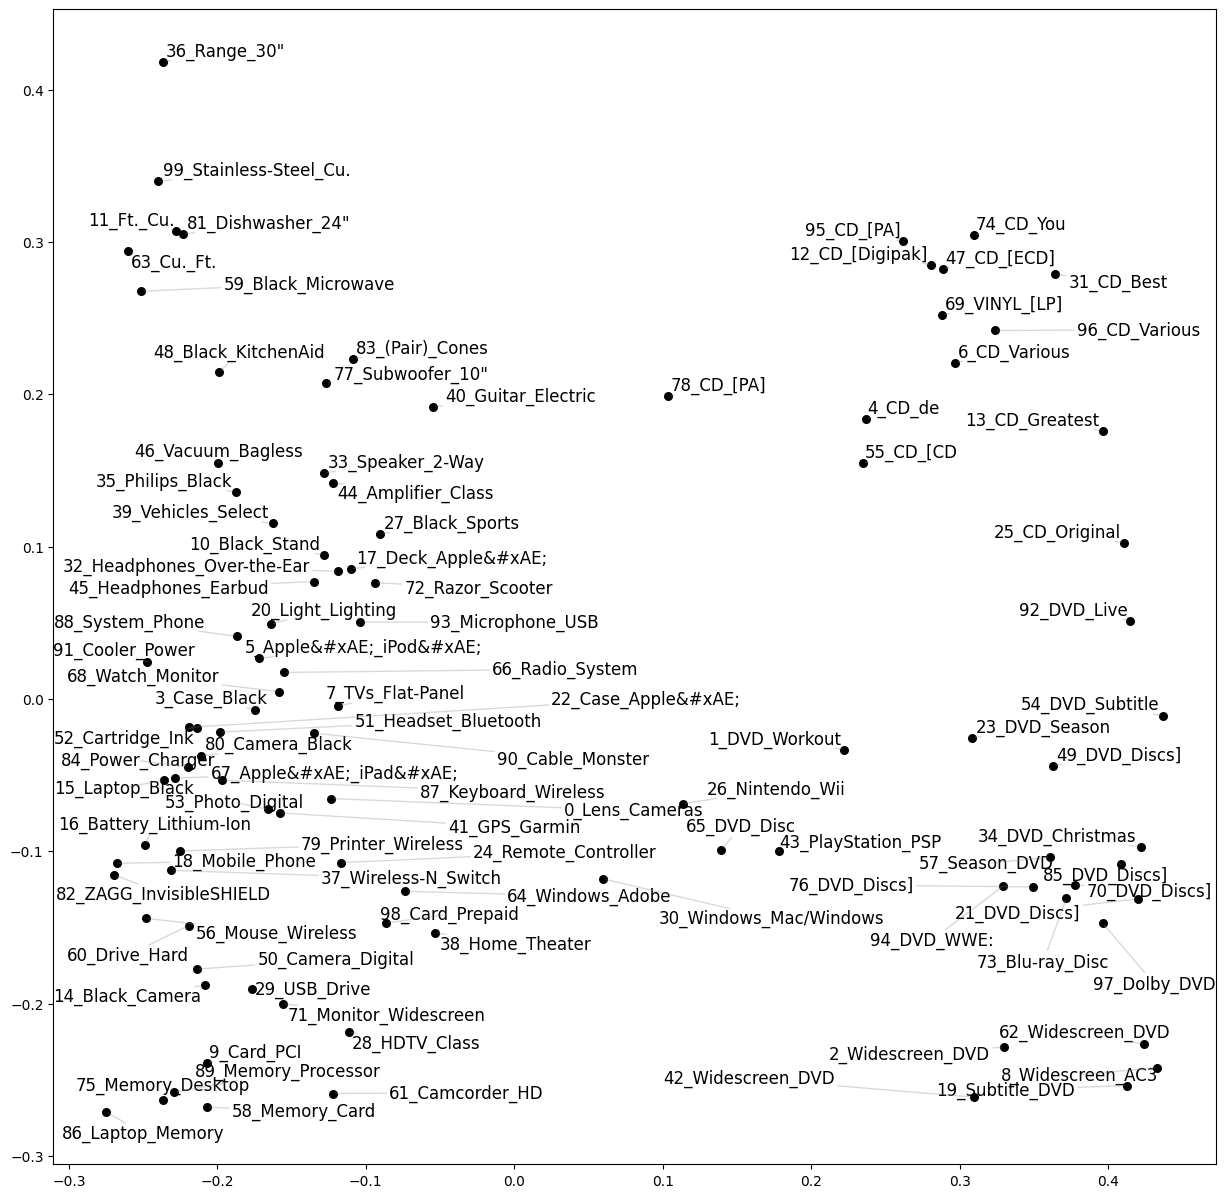

In [67]:
import collections, itertools, numpy as np, matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.decomposition import PCA

stopwords = ["in", "for", "with", "of", "the", "to", "and"]

def top_words(clusters, top_n):
    # Loop through the clusters and split each string on space
    tokenized = [cluster.split() for cluster in clusters]
    # Flatten the list of lists
    flattened = list(itertools.chain.from_iterable(tokenized))
    filtered = [word for word in flattened
                if len(word) > 1 and word.lower() not in stopwords]
    
    # Return the most common words
    return [word for word, _ 
            in collections.Counter(filtered).most_common(top_n)]

#Transform the data for 2-D visualization
plt.figure(figsize=(15,15))
pca = PCA(100, svd_solver="full")
plot_data = pca.fit_transform(centers)
#plot_data = centers
#plt.scatter(plot_data[:,0] , plot_data[:,1] , s = 30, color = 'k')

points = []
for i, cluster_name in enumerate(plot_data):
    plt.scatter(plot_data[i,0], plot_data[i,1], s=30, color="k") 
    label = f"{i}_{'_'.join(top_words(clusters[i], 2))}"
    points.append(plt.text(plot_data[i,0], plot_data[i,1], label, size=12))
adjust_text(points, arrowprops=dict(arrowstyle="-", color="gray", alpha=.3))

In [94]:
clusters[1]  #useful for spot checking clusters to ensure items inside are homogenous

['Music Pro Guides: Logic Pro 7 - Advanced Level - DVD',
 'Elite - DVD',
 'Fagbug - DVD',
 'MI-5, Vol. 1 [3 Discs] - DVD',
 'Masked and Anonymous - (Ws Sub Ac3 Dol) - DVD',
 'Tool: Schism - DVD',
 'Help! - DVD',
 'Inside Genesis: A Critical Review - 1975-1980 - Dts - DVD',
 'Mandingo - DVD',
 'Evangelion 2.0: You Can (Not) Advance - DVD',
 '35 Rhums - DVD',
 'Renovation Nation: Recycle Reuse & Reclaim - DVD',
 'The Ultimate Physics Tutor - Fullscreen - DVD',
 'Sony - 60-Minute MiniDV Digital Video Cassettes (6-Pack)',
 'Soca Gold 2009 [CD & DVD] - Various CD+DVD - CD',
 'Gidget: Complete Collection [2 Discs] - (Full) - DVD',
 'Funky Phantom [4 Discs] - Fullscreen - DVD',
 'Initial D: Stage 4 - Part Two (2 Disc) - DVD',
 'The NB Ridaz: Official DVD - DVD',
 'Chico Buarque: MPB Especial - DVD',
 'Tell Me Why: Computers/The Internet - DVD',
 'Rounders/Swingers [2 Discs] - DVD',
 'I Tried - DVD',
 'Maximum Overdrive/Raw Deal - DVD',
 'Dual Survival (2 Disc) - DVD',
 "Breakin' vs. Krumpin' 

In [68]:
#sample top keywords in each cluster (same as figure above, but more data)
for cluster_key in range(0,99):
    print(f"{{ cluster: {cluster_key}, top_words: {top_words(clusters[cluster_key], 20)}}}")

{ cluster: 0, top_words: ['Lens', 'Cameras', 'Nikon', 'Digital', 'Canon', 'SLR', 'Zoom', 'Filter', 'Tripod', 'Tiffen', 'Sony', 'Camera', 'Select', 'Telephoto', 'Nikkor', 'Series', '3D', 'Sunpak', 'USM', 'AF-S']}
{ cluster: 1, top_words: ['DVD', 'Workout', 'Yoga', 'Dance', 'Fullscreen', 'Pilates', 'Ultimate', 'Body', 'Training', 'Power', 'Jillian', 'Beginners', 'Fat', 'Cardio', 'Fitness', 'Sculpt', 'Weight', 'Dolby', 'Walk', 'Widescreen']}
{ cluster: 2, top_words: ['Widescreen', 'DVD', 'Subtitle', 'Dolby', 'AC3', 'Dubbed', 'Fullscreen', 'Dts', 'Blu-ray', 'Disc', 'UMD', 'Dead', 'Saw', 'One', 'Game', 'III', 'Man', 'State', 'Black', 'Out']}
{ cluster: 3, top_words: ['Case', 'Black', 'Logic', 'Most', 'Cases', 'Gator', 'Carrying', 'Camera', 'Digital', 'Guitars', 'Sony', 'Nintendo', 'Portable', 'Bag', 'CD', 'Lowepro', 'Hard', 'Cameras', 'Wallet', 'GPS']}
{ cluster: 4, top_words: ['CD', 'de', 'DVD', 'La', 'El', 'Various', 'Exitos', 'De', 'Los', 'Grandes', '[CD', 'DVD]', 'Vol.', 'En', 'el', 'Am

In [27]:
import pandas as pd

### Create Pandas dataframes for product_clusters
product_ids_labels = dict(zip(product_ids, labels))
pddf_product_ids_labels = pd.DataFrame.from_dict(product_ids_labels, orient="index", columns=["label"])
pddf_product_ids_labels["pid"] = pddf_product_ids_labels.index

## Listing 9.15 Comparing approaches for mapping queries to product clusters

In [34]:
import sentence_transformers, heapq

## get the top n clusters based on similairty with centers 
def get_top_labels_centers(query, centers, n=2):
    q_embedding = transformer.encode([query], convert_to_tensor=False)
    similarities = sentence_transformers.util.cos_sim(q_embedding, centers)
    sim = similarities.tolist()[0]
    return [sim.index(i) for i in heapq.nlargest(n, sim)]

### Get the cluster for the query based on prediction of the label
def get_query_cluster(query):
    q_embedding = transformer.encode([query], convert_to_tensor=False)
    return algo.predict(q_embedding)

In [71]:
def get_cluster_description(cluser_num):
    return "_".join(top_words(clusters[cluser_num], 5))

query = "microwave"
#option 1: Find nearest cluster (KMeans)
kmeans_predict = get_query_cluster(query)[0]
print("KMeans Predicted Cluster:")
print(f"    {kmeans_predict} ({get_cluster_description(kmeans_predict)})")

#option 2: Find most similar cluster (Cosine similarity)
closest_cosine_similarity = get_top_labels_centers(query, centers, 1)[0]
print(f"""\nCosine Predicted Cluster:\n    {closest_cosine_similarity}
      {get_cluster_description(closest_cosine_similarity)})""")

#option 3: N-nearest clusters (Cosine similarity)
knn_cosine_similarity = get_top_labels_centers(query, centers, 5)
print(f"\nKNN Cosine Predicted Clusters: {knn_cosine_similarity}")
for n in knn_cosine_similarity:
      print(f"    {n} ({get_cluster_description(n)})")

KMeans Predicted Cluster:
    59 (Black_Microwave_Cu._Ft._White)

Cosine Predicted Cluster:
    59 (Black_Microwave_Cu._Ft._White)

KNN Cosine Predicted Clusters: [59, 99, 48, 36, 11]
    59 (Black_Microwave_Cu._Ft._White)
    99 (Stainless-Steel_Cu._Ft._Microwave_Built-In)
    48 (Black_KitchenAid_Maker_Cuisinart_Stainless-Steel)
    36 (Range_30"_Self-Cleaning_Freestanding_Stainless-Steel)
    11 (Ft._Cu._Refrigerator_Water_Thru-the-Door)


In [28]:
sdf_id_labels = spark.createDataFrame(pddf_product_ids_labels).createOrReplaceTempView('products_clusters')

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [29]:
# Load signal data to create user-product vectors
create_view("signals", "signals")

In [30]:
#Create User-product data set for personalization
spark.sql("""SELECT DISTINCT user, target AS product_id, name AS product_name
FROM signals s JOIN products_samples p ON s.target = p.upc
""").createOrReplaceTempView("user_product")

query = """SELECT user, product_id, product_name, label FROM user_product a
JOIN products_clusters b ON a.product_id = b.pid"""

user_product_cluster_collection = "user_product_cluster"
create_collection(user_product_cluster_collection)
engine.populate_from_spark(user_product_cluster_collection, query)

Wiping 'user_product_cluster' collection
[('action', 'CREATE'), ('name', 'user_product_cluster'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'user_product_cluster' collection
Status: Success


In [31]:
## get the top n clusters based on similarity with centers 
def top_clusters_for_embedding(embedding, n=2):
    similarities = sentence_transformers.util.cos_sim(embedding, centers)
    sim = similarities.tolist()[0]
    return [sim.index(i) for i in heapq.nlargest(n, sim)]

## Listing 9.16

In [50]:
# importiong the modules
import pandas as pd
import numpy as np
np.set_printoptions(4)

#Take user's product interests and return dataframe containing embedding and guardrail cluster
def get_user_embeddings(products=[]):
    values = []
    for p in products:
        values.append([product_ids_emb[p], top_clusters_for_embedding(product_ids_emb[p], 1)[0]])
    column_names = ["embedding", "cluster"]
    return pd.DataFrame(data=np.array(values), index=products, columns=column_names)

def get_personalization_vector(query=None, user_items=[], query_weight=1, user_items_weights=[]):
    #by default, weight is split 1:1 (50% each) between the query embedding and the user_items_weight.
    #you can manually add weights for each user_item to influence how much each element counts.

    query_embedding = transformer.encode(query, convert_to_tensor=False) if query else None
    
    if len(user_items) > 0 and len(user_items_weights) == 0:
        user_items_weights = np.full(shape=len(user_items), fill_value=1 / len(user_items))
            
    embeddings = []
    embedding_weights = []
    for weight in user_items_weights:
        embedding_weights.append(weight) 
    for embedding in user_items:
        embeddings.append(embedding)
    if query_embedding.any():
        embedding_weights.append(query_weight)
        embeddings.append(query_embedding)
    
    return np.average(embeddings, weights=np.array(embedding_weights),
                      axis=0).astype("double") if len(embeddings) else None

## Listing 9.17

In [63]:
product_interests = [ "7610465823828",  #hello kitty water bottle
                      "36725569478"]   #stainless steel electric range

user_embeddings = get_user_embeddings(product_interests)
print(f"\nProducts Interactions for Personalization:\n {user_embeddings}")

query = "microwave"
unfiltered_personalization_vector = get_personalization_vector(query=query,
                        user_items=user_embeddings['embedding'].to_numpy())
print("\nPersonalization Vector (No Cluster Guardrails):")
print(str(unfiltered_personalization_vector[0:5]).replace("]", "... ]"))

query_clusters = get_top_labels_centers(query, centers, n=5)
print("\nQuery Clusters ('microwave'):", query_clusters)

filtered = user_embeddings[user_embeddings.cluster.isin(query_clusters)] #filter down to only items in the query clusters
print("\nProducts Filtered to Query Clusters:\n" + str(filtered))

filtered_personalization_vector = get_personalization_vector(query=query,
                             user_items=filtered['embedding'].to_numpy())

print("\nFiltered Personalization Vector (With Cluster Guardrails):")
print(str(filtered_personalization_vector[0:5]).replace("]", "... ]"))


Products Interactions for Personalization:
                                                        embedding cluster
7610465823828  [0.06417942, 0.041785527, -0.0017139543, -0.02...      27
36725569478    [0.0055417735, -0.024302173, -0.024139365, -0....      36

Personalization Vector (No Cluster Guardrails):
[ 0.0164 -0.0062 -0.02   -0.0317 -0.0161... ]

Query Clusters ('microwave'): [59, 99, 48, 36, 11]

Products Filtered to Query Clusters:
                                                     embedding cluster
36725569478  [0.0055417735, -0.024302173, -0.024139365, -0....      36

Filtered Personalization Vector (With Cluster Guardrails):
[ 0.0018 -0.0227 -0.0256 -0.0369 -0.0254... ]


/tmp/ipykernel_21217/24218764.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return pd.DataFrame(data=np.array(values), index=products,


## Listing 9.18

In [67]:
# 4- Get all items for the search query using solr index
## Get the top items from the query cluster for the user
### User search query using solr 
#query="Western Digital - Scorpio Blue 250GB Internal Serial ATA Hard Drive for Laptops Serial ATA interface; quiet performance; 1.5GB/sec data transfer rate"

query="microwave"
request = {
    "query": query, 
    "fields": ["upc", "name", "manufacturer", "score"], 
    "sort": "score desc, upc asc",
    "params": {
        "qf": "name manufacturer",
        "defType": "edismax",
        "rows": 100
    }
}

results = engine.search("products", request)
docs = engine.docs_from_response(results)
print("Search Results w/ No Personalization:")
display_product_search(query, docs[0:4])

Search Results w/ No Personalization:


In [68]:
from operator import itemgetter

def rerank_with_personalization(docs, personalization_vector):
    result_embeddings = np.array([product_ids_emb[docs[x]['upc']]
                                  for x in range(len(docs))]).astype(float)
    similarities = sentence_transformers.util.cos_sim(
        personalization_vector, result_embeddings).tolist()[0]
    reranked = [similarities.index(i)
                for i in heapq.nlargest(len(similarities), similarities)]
    reranked, v = zip(*sorted(enumerate(similarities),
                              key=itemgetter(1), reverse=True))
    return [docs[i] for i in reranked]
   
print("Personalized search results (no category guardrails):")
reranked_seach_results_no_guardrails = \
    rerank_with_personalization(docs, unfiltered_personalization_vector) 
display_product_search(query, reranked_seach_results_no_guardrails[0:4])

print("Personalized search results (with category guardrails):")
reranked_seach_results_with_guardrails = \
    rerank_with_personalization(docs, filtered_personalization_vector) 
display_product_search(query, reranked_seach_results_with_guardrails[0:4])


Personalized search results (no category guardrails):


Personalized search results (with category guardrails):


# Old ALS Code

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.sql.functions import col, explode

signals_collection = "signals"

# Load signals from Solr
signals_read_opts = {"zkhost": "aips-zk", "collection": signals_collection}
sql_filter = """select user, target, type
from signals
where user is not null and type='click'
"""
signals_df = spark.read.format("solr").options(**signals_read_opts).load()
signals_df.createOrReplaceTempView("signals")
signals_df = spark.sql(sql_filter)

# Encode 'user' and 'target' fields into integer IDs
indexer_user = StringIndexer(inputCol="user", outputCol="userId")
indexer_target = StringIndexer(inputCol="target", outputCol="itemId")

In [ ]:
index_model_user = indexer_user.fit(signals_df)
index_model_target = indexer_target.fit(signals_df)
signals_df = index_model_user.transform(signals_df)
signals_df = index_model_target.transform(signals_df)

# Prepare data for ALS model
data = signals_df.select(col("userId").cast("int"), 
                         col("itemId").cast("int"), 
                         col("type").cast("int"))

# Split the data into training and test sets
(training, test) = data.randomSplit([0.8, 0.2])



In [ ]:
# Initialize ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="itemId", ratingCol="type", coldStartStrategy="drop")

In [ ]:
# Train ALS model
model = als.fit(training)

In [ ]:
# Train ALS model
model = als.fit(training)

# Generate top 10 product recommendations for each user
userRecs = model.recommendForAllUsers(10)

# Mapping back the 'userId' and 'itemId' to original 'user' and 'target' values
user_to_string_indexer = IndexToString(inputCol="userId", outputCol="user", labels=index_model_user.labels)
item_to_string_indexer = IndexToString(inputCol="itemId", outputCol="target", labels=index_model_target.labels)

userRecs = user_to_string_indexer.transform(userRecs)

# To convert the recommendations from array format to multiple rows,
# we explode the recommendations array
userRecs = userRecs.withColumn("recommendations", explode(userRecs.recommendations))

userRecs = item_to_string_indexer.transform(userRecs)

# Display the recommendations
userRecs.select("user", "recommendations.target", "recommendations.rating").show()


Up next: Chapter 10 - [Learning to Rank for Generalizable Search Relevance](../ch10/1.setup-the-movie-db.ipynb)